In [5]:
import tensorflow as tf
#https://medium.com/%E8%BB%9F%E9%AB%94%E4%B9%8B%E5%BF%83/%E9%81%A9%E5%90%88%E5%A4%A7%E9%87%8F%E8%B3%87%E6%96%99i-o%E7%9A%84%E5%84%B2%E5%AD%98%E6%A0%BC%E5%BC%8F-tfrecord%E7%B0%A1%E4%BB%8B%E8%88%87%E6%93%8D%E4%BD%9C%E6%95%99%E5%AD%B8-cd27e50d51ee

# mnist one example consists of 28*28 byte + 1 byte
# if _bytes_feature's args is alreaddy a list, no need to use []
def _image_feature(value):
    """"Returns a uint8(byte)_list from a byte."""
    if isinstance(value, type(tf.constant(0))):
        # BytesList won't unpack a string from an EagerTensor.
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _label_feature(value):
    """Returns a uint8(byte)_list from a byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [40]:
""" transfer dataset to tfrecord method"""
# the whole image is a byte feature, not a byte list
import os
import struct                                                                   
import numpy as np                                                              
import matplotlib.pyplot as plt                                                 
from PIL import Image
def serialize_example(_label, _image):
    feature = {
        "label": _label_feature(_label),
        "image": _image_feature(_image),
        }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString() 

images_file_name = './train-images.idx3-ubyte'
labels_file_name = './train-labels.idx1-ubyte'
images_dir = './mnist jpeg/'
mnist_images=open(images_file_name,'rb')
mnist_labels=open(labels_file_name,'rb')
# skip header file
_=mnist_images.read(16)
_=mnist_labels.read(8)

# data
# build offset_table while writing TFRecords, int64 for offset of each instance, e.g. offset of instance #100 is 100*8B=800B
# byte is little endian
offset_table=open("mnist-sparse_padded-offset_table",'wb') 

with tf.io.TFRecordWriter("mnist_sparse_padded.tfrecords") as writer:
    # page size=4KB, padding to write to another page if the next instance exceeds the page
    
    """padding needs to ne slightly modified: because padded record needs at least 16B, 
    instead of see if after_ptr exceeds, see if after_ptr+16 exceeds """
    
    cur_page=0
    for i in range (60000):
        # current tfr file ptr = current_filesize
        with open(images_dir+str(i)+'.jpg','rb') as f:
            buf=mnist_labels.read(1)
            _label=buf
            img_bytes=f.read()            
            
            current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords")
            # test if exceeds or not, other 3 columns: 16B
            cur_page=int(current_filesize/4096)
            serialized_example = serialize_example(_label, img_bytes)
            calc_new_filesize=current_filesize+len(serialized_example)+16+16
            calc_new_page=int(calc_new_filesize/4096)            
            
            if(calc_new_page>cur_page):
                # if exceeds: padding until reaching new page
                #TODO: the pad still needs 16B metadata
                pad_len=calc_new_page*4096-current_filesize
                #print("before pad:",current_filesize)
                pad=b''
                if(pad_len-16>0):                    
                    for _ in range (pad_len-16):
                        pad+=b'0'
                    #print("len(pad)=",len(pad))
                    writer.write(pad)
                    #current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords") 
                    #print("after pad",current_filesize)
                else:
                    print("error")
            current_filesize=os.path.getsize("mnist_sparse_padded.tfrecords") 
            #print("after after pad",current_filesize)
            if(i%4000==0):
                print(i,end=' ')
                print("offset=",current_filesize)
            """
            if(i<10):
                print(current_filesize,calc_new_filesize,end=' ')
                print(cur_page,calc_new_page, end=' ')
                print(len(serialized_example))
            else:
                break
            """    
            offset_table.write(current_filesize.to_bytes(8, byteorder = 'little')) 
            writer.write(serialized_example)

0 offset= 0
4000 offset= 2720357
8000 offset= 5440147
12000 offset= 8161859
16000 offset= 10880771
20000 offset= 13597054
24000 offset= 16320380
28000 offset= 19037277
32000 offset= 21751540
36000 offset= 24468494
40000 offset= 27184230
44000 offset= 29902677
48000 offset= 32623537
52000 offset= 35341560
56000 offset= 38058426


In [ ]:
""" standard way to iterate tfr, to make sure the tfr format is right """

dataset = tf.data.TFRecordDataset('mnist_sparse.tfrecords')

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.string),
    # var len is different
    'image': tf.io.FixedLenFeature([],tf.string),
}

def _parse_function(example_proto):
    serialized_example = tf.io.parse_single_example(example_proto, image_feature_description)
    return serialized_example


for idx, features in enumerate(dataset):
    parsed_features = _parse_function(features)
    print("label=",parsed_features['label'].numpy())    
    image=tf.io.decode_jpeg(parsed_features['image'])
    plt.imshow(np.asarray(image).reshape((28,28)),cmap = plt.cm.gray)                                        
    plt.show()
    
    if idx>=11:
        break

In [41]:
"""offset table read test"""

oft=open("mnist-sparse_padded-offset_table",'rb')
idx=5
for i in range (60000):
    
    tmp=oft.read(8)
    #print(tmp)
    if(i%4000==0):
        length=struct.unpack("<Q",tmp)
        print(length[0])

0
2720357
5440147
8161859
10880771
13597054
16320380
19037277
21751540
24468494
27184230
29902677
32623537
35341560
38058426


In [44]:
""" the actual read() function """

def sparse_random_read(binfile, oft, idx):
    # read offset, 8B per instance
    #TODO: oft should be loaded to mem
    oft.seek(idx*8,0)
    tmp=oft.read(8)
    offset=struct.unpack("<Q",tmp)[0]
    print("offset=",offset)
    
    # read data length
    binfile.seek(offset,0)
    tmp=binfile.read(8)
    length=struct.unpack("<Q",tmp)[0]
    print("length=",length)
    # we already read first 8B
    record_l_from_col2=length+8
    
    # random read
    tmp=binfile.read(record_l_from_col2)
    r_data=tmp[4:-4]

    # deserialize data
    parsed_features = _parse_function(r_data)
    return parsed_features
    
    

offset= 4389853
length= 604
tf.Tensor(b'\x07', shape=(), dtype=string)


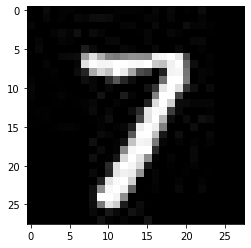

In [45]:
""" test read() function """

binfile=open('mnist_sparse_padded.tfrecords','rb')
oftfile=open('mnist-sparse_padded-offset_table','rb')
parsed_feature=sparse_random_read(binfile,oftfile, 6455)
image=tf.io.decode_jpeg(parsed_feature['image'])
print(parsed_feature['label'])
np_image=np.frombuffer(image, dtype='>B').astype(np.uint8)
plt.imshow(np.asarray(np_image).reshape((28,28)),cmap = plt.cm.gray)                                        
plt.show()